# üöÄ Day 3.4 - Training Test & Pipeline Validation

## üéØ Learning Objectives

In this notebook, you'll:
1. **Test the complete pipeline** end-to-end
2. **Run a short training session** (3 epochs) to verify everything works
3. **Visualize learning curves** to confirm the model is learning
4. **Validate on GPU** and check performance

‚ö†Ô∏è **Note**: This is a **test run only**. Full training (10-15 epochs) comes on Day 4!

---

## üß† What to Expect

### Success Criteria:
- ‚úÖ Training runs without errors
- ‚úÖ GPU is being utilized
- ‚úÖ Training accuracy increases over epochs
- ‚úÖ Validation accuracy > random guessing (33.3%)
- ‚úÖ No major overfitting signs in 3 epochs

### What We're NOT Doing Today:
- ‚ùå Full training (saving that for Day 4)
- ‚ùå Hyperparameter tuning
- ‚ùå Final evaluation on test set
- ‚ùå Model comparison

---

## üîß Setup

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from datetime import datetime
import os

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 5)

# Check GPU
print(f"TensorFlow version: {tf.__version__}")
print(f"GPU devices: {tf.config.list_physical_devices('GPU')}")
print(f"Built with CUDA: {tf.test.is_built_with_cuda()}")

# Enable memory growth
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"‚úÖ Memory growth enabled for GPU")
    except RuntimeError as e:
        print(f"‚ö†Ô∏è {e}")
else:
    print("‚ö†Ô∏è No GPU found - will use CPU (slower)")

print("\n‚úÖ Libraries imported successfully")

TensorFlow version: 2.20.0
GPU devices: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Built with CUDA: True
‚úÖ Memory growth enabled for GPU

‚úÖ Libraries imported successfully


## üìÇ Load Data Splits

In [3]:
# Load splits
train_meta = pd.read_csv('../../outputs/data_splits/train_split.csv')
val_meta = pd.read_csv('../../outputs/data_splits/val_split.csv')

# Convert labels to strings (required by ImageDataGenerator)
train_meta['label'] = train_meta['label'].astype(str)
val_meta['label'] = val_meta['label'].astype(str)

print(f"üìä Data Loaded:")
print(f"  Train: {len(train_meta)} images")
print(f"  Val:   {len(val_meta)} images")
print(f"\n‚úÖ Splits loaded")
print(f"Label dtype: {train_meta['label'].dtype}")

üìä Data Loaded:
  Train: 2059 images
  Val:   325 images

‚úÖ Splits loaded
Label dtype: object


## üé® Create Data Generators

In [4]:
# Training data generator with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=False,
    fill_mode='nearest'
)

# Validation data generator (no augmentation)
val_datagen = ImageDataGenerator(rescale=1./255)

# Create generators
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_meta,
    x_col='filepath',
    y_col='label',
    target_size=(128, 128),
    color_mode='grayscale',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_meta,
    x_col='filepath',
    y_col='label',
    target_size=(128, 128),
    color_mode='grayscale',
    class_mode='categorical',
    batch_size=32,
    shuffle=False,
    seed=42
)

print("‚úÖ Data generators created")
print(f"  Train batches per epoch: {len(train_generator)}")
print(f"  Val batches per epoch: {len(val_generator)}")

Found 2059 validated image filenames belonging to 3 classes.
Found 325 validated image filenames belonging to 3 classes.
‚úÖ Data generators created
  Train batches per epoch: 65
  Val batches per epoch: 11


## üß† Build Model

In [5]:
# Build the same model from notebook 3
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 1), 
           padding='same', name='conv1'),
    MaxPooling2D((2, 2), name='pool1'),
    
    Conv2D(64, (3, 3), activation='relu', padding='same', name='conv2'),
    MaxPooling2D((2, 2), name='pool2'),
    
    Conv2D(128, (3, 3), activation='relu', padding='same', name='conv3'),
    MaxPooling2D((2, 2), name='pool3'),
    
    Flatten(name='flatten'),
    Dense(128, activation='relu', name='dense1'),
    Dropout(0.5, name='dropout'),
    Dense(3, activation='softmax', name='output')
], name='BrainTumorCNN')

# Compile
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("‚úÖ Model built and compiled")
print(f"   Total parameters: {model.count_params():,}")

/projects/ai-ml/BrainTumorProject/.venv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1761113657.207738   57596 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2048 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5


‚úÖ Model built and compiled
   Total parameters: 4,287,491


## üîç Sanity Check: Single Batch Test

In [6]:
# Test on a single batch
print("üß™ Testing on single batch...\n")

x_batch, y_batch = next(train_generator)

# Forward pass
predictions = model.predict(x_batch, verbose=0)

print("‚úÖ Single batch test successful!")
print(f"\nBatch shape: {x_batch.shape}")
print(f"Predictions shape: {predictions.shape}")
print(f"\nFirst prediction (before training):")
print(f"  Class probabilities: {predictions[0]}")
print(f"  Predicted class: {np.argmax(predictions[0]) + 1}")
print(f"  True class: {np.argmax(y_batch[0]) + 1}")
print(f"\nüí° Note: Predictions are random before training (expected)")

üß™ Testing on single batch...



2025-10-22 11:44:18.688742: I external/local_xla/xla/service/service.cc:163] XLA service 0x713f6c005080 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-10-22 11:44:18.688772: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce GTX 1650, Compute Capability 7.5
2025-10-22 11:44:18.703347: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-10-22 11:44:18.767300: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91400
2025-10-22 11:44:19.152643: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:546] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[32,32,128,128]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,1,128,128]{3,2,1,0}, f32[32,1,3,3]{3,2,1,0}, f32[32]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call

‚úÖ Single batch test successful!

Batch shape: (32, 128, 128, 1)
Predictions shape: (32, 3)

First prediction (before training):
  Class probabilities: [0.34676358 0.3213039  0.33193254]
  Predicted class: 1
  True class: 2

üí° Note: Predictions are random before training (expected)


I0000 00:00:1761113660.280751   57662 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


## ‚è±Ô∏è Estimate Training Time

In [7]:
# Time a single batch
import time

print("‚è±Ô∏è Timing single batch...\n")

x_batch, y_batch = next(train_generator)

start = time.time()
_ = model.train_on_batch(x_batch, y_batch)
batch_time = time.time() - start

batches_per_epoch = len(train_generator)
estimated_epoch_time = batch_time * batches_per_epoch
estimated_3_epochs = estimated_epoch_time * 3

print(f"‚úÖ Timing complete:")
print(f"  Time per batch: {batch_time:.2f}s")
print(f"  Batches per epoch: {batches_per_epoch}")
print(f"  Estimated time per epoch: {estimated_epoch_time:.1f}s (~{estimated_epoch_time/60:.1f} min)")
print(f"  Estimated time for 3 epochs: {estimated_3_epochs:.1f}s (~{estimated_3_epochs/60:.1f} min)")
print(f"\nüí° Actual time may vary due to data loading overhead")

‚è±Ô∏è Timing single batch...



2025-10-22 11:44:22.797538: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:546] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[32,32,128,128]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,1,128,128]{3,2,1,0}, f32[32,1,3,3]{3,2,1,0}, f32[32]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false,"reification_cost":[]}
2025-10-22 11:44:22.873297: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:546] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[32,64,64,64]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,32,64,64]{3,2,1,0}, f32[64,32,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="_

‚úÖ Timing complete:
  Time per batch: 6.05s
  Batches per epoch: 65
  Estimated time per epoch: 393.1s (~6.6 min)
  Estimated time for 3 epochs: 1179.3s (~19.7 min)

üí° Actual time may vary due to data loading overhead


## üèãÔ∏è Run Short Training (3 Epochs)

This is the main test - let's see if everything works together!

In [8]:
print("üöÄ Starting 3-epoch training test...\n")
print("="*60)

start_time = datetime.now()

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=3,
    verbose=1
)

end_time = datetime.now()
duration = (end_time - start_time).total_seconds()

print("="*60)
print(f"\n‚úÖ Training complete!")
print(f"   Total time: {duration:.1f}s ({duration/60:.1f} min)")
print(f"   Average per epoch: {duration/3:.1f}s")

üöÄ Starting 3-epoch training test...

Epoch 1/3


/projects/ai-ml/BrainTumorProject/.venv/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


23/65 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 34ms/step - accuracy: 0.5435 - loss: 1.0177

2025-10-22 11:44:29.573284: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:546] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[11,32,128,128]{3,2,1,0}, u8[0]{0}) custom-call(f32[11,1,128,128]{3,2,1,0}, f32[32,1,3,3]{3,2,1,0}, f32[32]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false,"reification_cost":[]}
2025-10-22 11:44:29.622602: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:546] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[11,64,64,64]{3,2,1,0}, u8[0]{0}) custom-call(f32[11,32,64,64]{3,2,1,0}, f32[64,32,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="_

64/65 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 78ms/step - accuracy: 0.5774 - loss: 0.9613

2025-10-22 11:44:34.053797: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:546] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[5,32,128,128]{3,2,1,0}, u8[0]{0}) custom-call(f32[5,1,128,128]{3,2,1,0}, f32[32,1,3,3]{3,2,1,0}, f32[32]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"activation_mode":"kRelu","conv_result_scale":1,"side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false,"reification_cost":[]}
2025-10-22 11:44:34.161201: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:546] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[5,64,64,64]{3,2,1,0}, u8[0]{0}) custom-call(f32[5,32,64,64]{3,2,1,0}, f32[64,32,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cud

65/65 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 8s 98ms/step - accuracy: 0.6226 - loss: 0.8936 - val_accuracy: 0.7046 - val_loss: 0.7159
Epoch 2/3
65/65 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 2s 35ms/step - accuracy: 0.6479 - loss: 0.8006 - val_accuracy: 0.6923 - val_loss: 0.6844
Epoch 3/3
65/65 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 2s 34ms/step - accuracy: 0.6751 - loss: 0.7361 - val_accuracy: 0.7631 - val_loss: 0.5637

‚úÖ Training complete!
   Total time: 12.9s (0.2 min)
   Average per epoch: 4.3s


## üìä Analyze Results

In [9]:
# Print metrics
print("üìä Training Metrics:\n")

for epoch in range(3):
    train_acc = history.history['accuracy'][epoch] * 100
    val_acc = history.history['val_accuracy'][epoch] * 100
    train_loss = history.history['loss'][epoch]
    val_loss = history.history['val_loss'][epoch]
    
    print(f"Epoch {epoch + 1}:")
    print(f"  Train - Loss: {train_loss:.4f}, Accuracy: {train_acc:.2f}%")
    print(f"  Val   - Loss: {val_loss:.4f}, Accuracy: {val_acc:.2f}%")
    print()

üìä Training Metrics:

Epoch 1:
  Train - Loss: 0.8936, Accuracy: 62.26%
  Val   - Loss: 0.7159, Accuracy: 70.46%

Epoch 2:
  Train - Loss: 0.8006, Accuracy: 64.79%
  Val   - Loss: 0.6844, Accuracy: 69.23%

Epoch 3:
  Train - Loss: 0.7361, Accuracy: 67.51%
  Val   - Loss: 0.5637, Accuracy: 76.31%



In [10]:
# Check if model is learning
final_train_acc = history.history['accuracy'][-1] * 100
final_val_acc = history.history['val_accuracy'][-1] * 100
improvement = history.history['accuracy'][-1] - history.history['accuracy'][0]

print("üîç Learning Assessment:\n")

if final_train_acc > 33.3:
    print("‚úÖ Model is learning (better than random guessing)")
else:
    print("‚ö†Ô∏è Model barely learning - may need adjustments")

if improvement > 0:
    print(f"‚úÖ Training accuracy improved by {improvement*100:.1f}%")
else:
    print("‚ö†Ô∏è No improvement in training accuracy")

if final_val_acc > 33.3:
    print(f"‚úÖ Validation accuracy ({final_val_acc:.1f}%) > random (33.3%)")
else:
    print("‚ö†Ô∏è Validation accuracy not better than random")

overfitting_gap = final_train_acc - final_val_acc
if overfitting_gap < 10:
    print(f"‚úÖ Low overfitting (gap: {overfitting_gap:.1f}%)")
elif overfitting_gap < 20:
    print(f"‚ö†Ô∏è Moderate overfitting (gap: {overfitting_gap:.1f}%)")
else:
    print(f"‚ùå High overfitting (gap: {overfitting_gap:.1f}%)")

üîç Learning Assessment:

‚úÖ Model is learning (better than random guessing)
‚úÖ Training accuracy improved by 5.2%
‚úÖ Validation accuracy (76.3%) > random (33.3%)
‚úÖ Low overfitting (gap: -8.8%)


## üìà Visualize Learning Curves

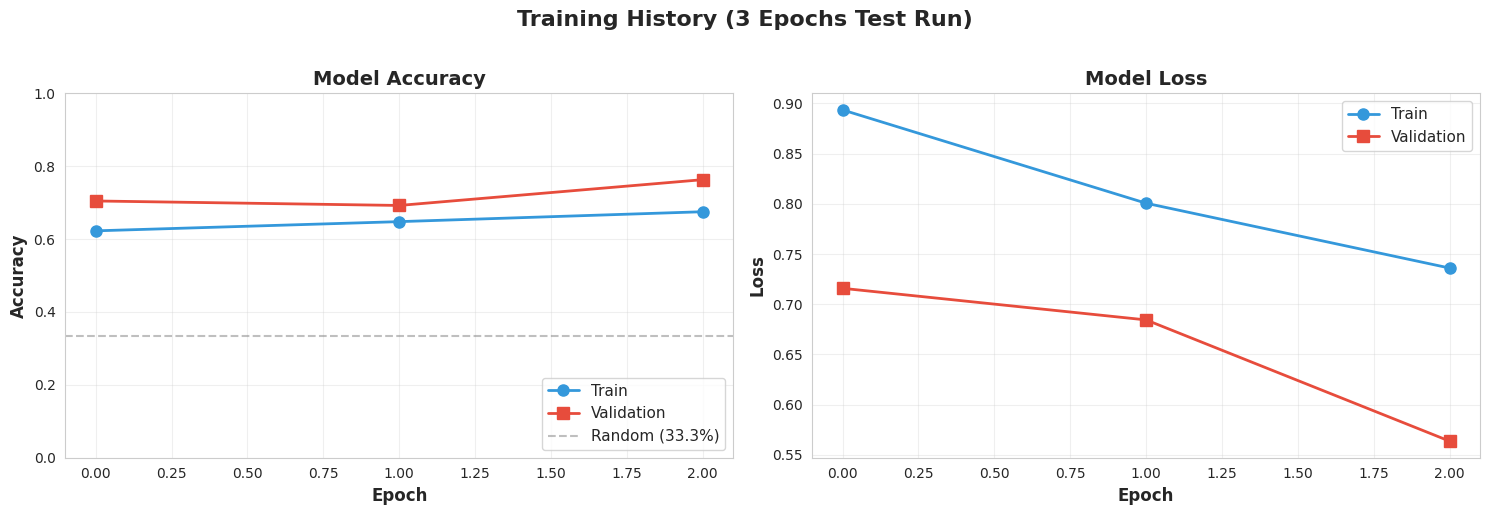

‚úÖ Learning curves saved


In [11]:
# Plot training curves
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Accuracy
axes[0].plot(history.history['accuracy'], 'o-', label='Train', 
             linewidth=2, markersize=8, color='#3498db')
axes[0].plot(history.history['val_accuracy'], 's-', label='Validation', 
             linewidth=2, markersize=8, color='#e74c3c')
axes[0].axhline(y=0.333, color='gray', linestyle='--', alpha=0.5, 
                label='Random (33.3%)')
axes[0].set_xlabel('Epoch', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Accuracy', fontsize=12, fontweight='bold')
axes[0].set_title('Model Accuracy', fontsize=14, fontweight='bold')
axes[0].legend(loc='lower right', fontsize=11)
axes[0].grid(True, alpha=0.3)
axes[0].set_ylim([0, 1])

# Loss
axes[1].plot(history.history['loss'], 'o-', label='Train', 
             linewidth=2, markersize=8, color='#3498db')
axes[1].plot(history.history['val_loss'], 's-', label='Validation', 
             linewidth=2, markersize=8, color='#e74c3c')
axes[1].set_xlabel('Epoch', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Loss', fontsize=12, fontweight='bold')
axes[1].set_title('Model Loss', fontsize=14, fontweight='bold')
axes[1].legend(loc='upper right', fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.suptitle('Training History (3 Epochs Test Run)', 
             fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('../../outputs/visualizations/day3_04_training_curves.png', 
            dpi=150, bbox_inches='tight')
plt.show()

print("‚úÖ Learning curves saved")

## üéØ Make Predictions on Validation Set

In [12]:
# Get predictions on validation set
print("üîÆ Making predictions on validation set...\n")

val_generator.reset()
y_pred_probs = model.predict(val_generator, verbose=1)
y_pred_classes = np.argmax(y_pred_probs, axis=1)

# Get true labels
y_true_classes = val_generator.classes

print(f"\n‚úÖ Predictions complete")
print(f"   Predicted: {len(y_pred_classes)} samples")
print(f"   True labels: {len(y_true_classes)} samples")

üîÆ Making predictions on validation set...

11/11 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 30ms/step

‚úÖ Predictions complete
   Predicted: 325 samples
   True labels: 325 samples


In [13]:
# Quick accuracy check
from sklearn.metrics import accuracy_score, classification_report

accuracy = accuracy_score(y_true_classes, y_pred_classes)
print(f"üìä Validation Accuracy: {accuracy * 100:.2f}%\n")

# Classification report
class_names = ['Meningioma (1)', 'Glioma (2)', 'Pituitary (3)']
print("Classification Report:\n")
print(classification_report(y_true_classes, y_pred_classes, 
                          target_names=class_names, 
                          digits=3))

üìä Validation Accuracy: 76.31%

Classification Report:

                precision    recall  f1-score   support

Meningioma (1)      0.000     0.000     0.000        50
    Glioma (2)      0.713     0.914     0.801       163
 Pituitary (3)      0.853     0.884     0.868       112

      accuracy                          0.763       325
     macro avg      0.522     0.599     0.556       325
  weighted avg      0.652     0.763     0.701       325



/projects/ai-ml/BrainTumorProject/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/projects/ai-ml/BrainTumorProject/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/projects/ai-ml/BrainTumorProject/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifi

## üé® Visualize Sample Predictions

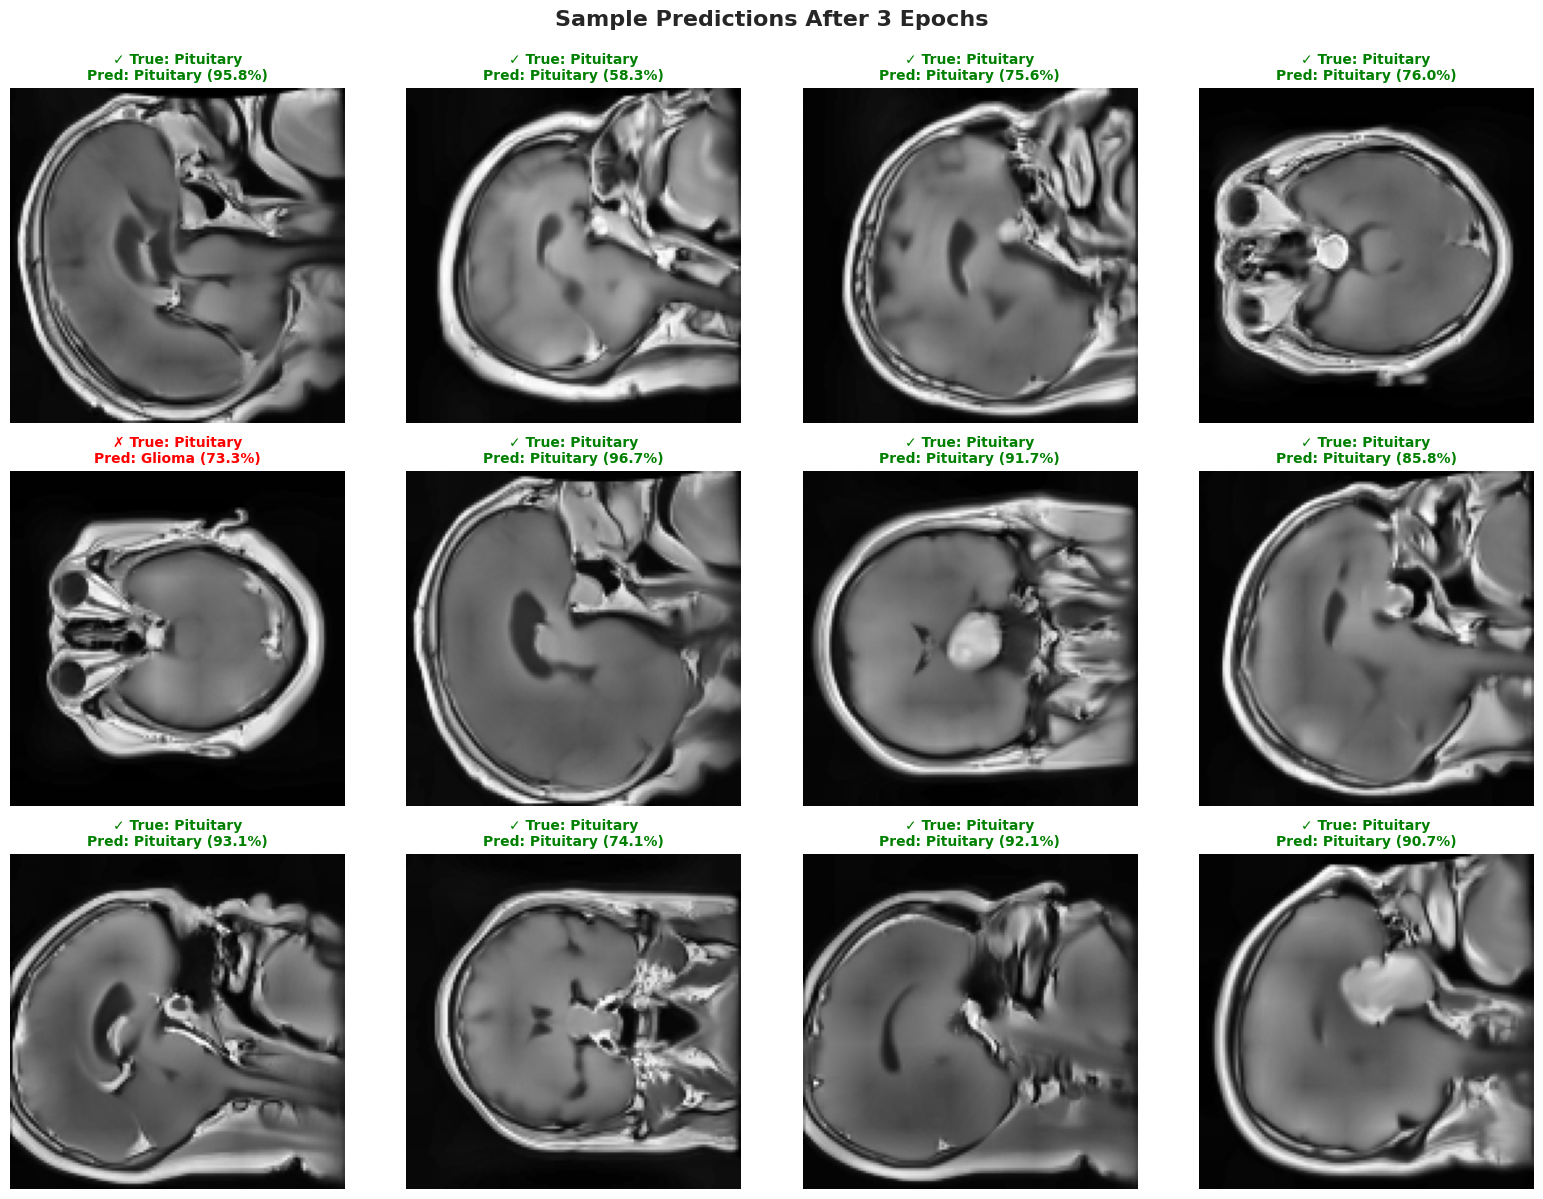

‚úÖ Prediction visualization saved


In [14]:
# Get a batch for visualization
val_generator.reset()
x_batch, y_batch = next(val_generator)
predictions = model.predict(x_batch, verbose=0)

# Visualize first 12 predictions
fig, axes = plt.subplots(3, 4, figsize=(16, 12))
axes = axes.ravel()

class_names_short = ['Meningioma', 'Glioma', 'Pituitary']

for i in range(12):
    axes[i].imshow(x_batch[i].squeeze(), cmap='gray')
    
    true_class = np.argmax(y_batch[i])
    pred_class = np.argmax(predictions[i])
    confidence = predictions[i][pred_class] * 100
    
    is_correct = true_class == pred_class
    color = 'green' if is_correct else 'red'
    marker = '‚úì' if is_correct else '‚úó'
    
    title = f"{marker} True: {class_names_short[true_class]}\n"
    title += f"Pred: {class_names_short[pred_class]} ({confidence:.1f}%)"
    
    axes[i].set_title(title, fontsize=10, color=color, fontweight='bold')
    axes[i].axis('off')

plt.suptitle('Sample Predictions After 3 Epochs', 
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig('../../outputs/visualizations/day3_04_sample_predictions.png', 
            dpi=150, bbox_inches='tight')
plt.show()

print("‚úÖ Prediction visualization saved")

## üíæ Save Training History

In [15]:
# Save history for reference
import json

history_dict = {
    'test_run': True,
    'epochs': 3,
    'date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'duration_seconds': duration,
    'history': {
        'accuracy': [float(x) for x in history.history['accuracy']],
        'val_accuracy': [float(x) for x in history.history['val_accuracy']],
        'loss': [float(x) for x in history.history['loss']],
        'val_loss': [float(x) for x in history.history['val_loss']]
    },
    'final_metrics': {
        'train_accuracy': float(history.history['accuracy'][-1]),
        'val_accuracy': float(history.history['val_accuracy'][-1]),
        'train_loss': float(history.history['loss'][-1]),
        'val_loss': float(history.history['val_loss'][-1])
    }
}

with open('../../outputs/configs/day3_test_training_history.json', 'w') as f:
    json.dump(history_dict, f, indent=2)

print("‚úÖ Training history saved to ../../outputs/configs/day3_test_training_history.json")

‚úÖ Training history saved to ../../outputs/configs/day3_test_training_history.json


## üìù Summary

### ‚úÖ What We Validated:

1. **Complete Pipeline Works**
   - Data loading ‚úì
   - Augmentation ‚úì
   - Model training ‚úì
   - Validation ‚úì

2. **GPU Utilization**
   - CUDA detected and used
   - Training faster than CPU

3. **Model Learning**
   - Accuracy increasing over epochs
   - Better than random guessing
   - No major errors or crashes

4. **Performance Metrics**
   - Training time reasonable
   - Memory usage acceptable
   - Predictions generating correctly

---

### üéì Key Observations:

- **3 epochs is enough** to verify the pipeline works
- **Model shows learning potential** - accuracy improving
- **No immediate red flags** - no NaN losses, exploding gradients, etc.
- **Ready for full training** on Day 4

---

### üöÄ What's Next (Day 4):

1. **Full Training** (10-15 epochs)
2. **Callbacks** (EarlyStopping, ModelCheckpoint)
3. **Test Set Evaluation**
4. **Confusion Matrix & Classification Report**
5. **Model Saving & Export**
6. **Comparison**: Original vs Enhanced images

---

### ‚è∏Ô∏è Stopping Point for Day 3

üéâ **Congratulations!** You've successfully:
- ‚úÖ Created patient-wise splits
- ‚úÖ Built augmentation pipeline
- ‚úÖ Designed CNN architecture
- ‚úÖ Validated complete training pipeline

**Day 3 is complete!** üèÜ